## ABC applied to position reconstruction

*Bart Pelssers, 26-02-2018*

This notebook provides some ingredients for applying the ABC algorithm to position reconstruction, the most basic case. Just to test the framework.


* Provides:
  * prior mean
  * forward model
  * summary statistic

In [1]:
import numpy as np

In [2]:
# Using the XENON1T data processor
from pax import utils
from pax.configuration import load_configuration
from pax.PatternFitter import PatternFitter
from pax.plugins.io.WaveformSimulator import uniform_circle_rv

You don't have ROOT or root_pandas, root truth file output is disabled


In [3]:
class PriorPosition():
    """Implements the calculation of the mean of a prior
       given a pattern (either from data or from the forward model)
    """
    
    def __init__(self):
        # Get some settings from the XENON1T detector configuration
        config = load_configuration('XENON1T')
        
        # PMT positions
        pmt_config = config['DEFAULT']['pmts']
        
        # List of dicts {'x': , 'y'}, which the position
        self.positions = [pmt['position'] for pmt in pmt_config][:127]

    def __call__(self, pattern):
        # The id of the PMT that sees most light
        max_pmt = np.argmax(pattern)
        
        # The position of that PMT
        pos = self.positions[max_pmt]
        
        return pos['x'], pos['y']        
        

class Model():
    """Implements the forward model for ABC project.
    
       The forward model used here is the most basic test case.
       It draws from the per-PMT S2 LCE maps to provide a
       hitpattern for a given x,y. Assumes all top PMTs live.
       Also the total number of detected photo-electrons needs to
       be specified, this is set constant by default.
    """

    def __init__(self):
        # Get some settings from the XENON1T detector configuration
        config = load_configuration('XENON1T')
        
        # The per-PMT S2 LCE maps (and zoom factor which is a technical detail)
        lce_maps = config['WaveformSimulator']['s2_patterns_file']
        lce_map_zoom = config['WaveformSimulator']['s2_patterns_zoom_factor']

        # Simulate the right PMT response
        qes = np.array(config['DEFAULT']['quantum_efficiencies'])
        top_pmts = config['DEFAULT']['channels_top']
        errors = config['DEFAULT']['relative_qe_error'] + config['DEFAULT']['relative_gain_error']

        # Set up the PatternFitter which sample the LCE maps
        self.pf = PatternFitter(filename=utils.data_file_name(lce_maps),
                                zoom_factor=lce_map_zoom,
                                adjust_to_qe=qes[top_pmts],
                                default_errors=errors)

    def __call__(self, x, y, n_obs = 500):
        """Returns a hitpattern of n_obs photo-electrons
           for given x, y position.
        """
        
        return n_obs * self.pf.expected_pattern((x, y))


class Generator():
    """Generates test hitpatterns by drawing from LCE maps (forward model)"""
    
    def __init__(self, model):
        # Get some settings from the XENON1T detector configuration
        config = load_configuration('XENON1T')
        self.tpc_radius = config['DEFAULT']['tpc_radius']
        
        # Use the forward model also as generator for now
        self.model = model
    
    def __call__(self):
        return self.model(*uniform_circle_rv(self.tpc_radius))

In [4]:
# Setup the Models
model = Model()
prior_mean = PriorPosition()
generator = Generator(model)

In [5]:
# Example pattern from some unknown x,y position
generator()

array([  0.89593613,   0.55337818,   0.58689273,   0.47171583,
         0.28723324,   0.48338636,   0.32073939,   0.40041972,
         0.34548325,   0.35697107,   0.27514878,   0.26588176,
         0.38396175,   0.29961561,   0.37439128,   0.40000699,
         0.34299432,   0.28187137,   0.3592507 ,   0.61287027,
         0.33165501,   0.48972627,   0.41780896,   0.66553855,
         0.63979629,   0.77564647,   1.23229133,   1.77073408,
         3.234718  ,   8.99752181,  26.92533933,  36.81775468,
        17.25044176,   5.52992475,   2.34364439,   1.39577918,
         1.35017945,   1.11307121,   0.76837082,   0.68908675,
         0.74666928,   0.832106  ,   0.67306562,   0.66999703,
         0.66476075,   0.68034571,   0.72456624,   0.66490088,
         0.62026226,   0.62045237,   0.56075331,   0.75543873,
         0.70490042,   0.79567617,   0.71308609,   0.85567637,
         0.91214977,   1.13424607,   1.77209101,   3.65981681,
        12.06967789,  68.64098872,  90.1781484 ,  17.87

In [6]:
# Example pattern from x=24, y=-12

# The range of x and y is [-47.884375 cm, -47.884375 cm]
# But x**2 + y**2 < 47.884375**2
# Otherwise m() will raise and exception

pattern = model(24, -12)

print("Length of pattern: %d, Sum of pattern: %.2f" % (len(pattern), pattern.sum()))
print(pattern)

Length of pattern: 127, Sum of pattern: 500.00
[  0.38380166   0.41537353   0.39553333   0.50098828   0.52944289
   0.58591603   0.56589008   0.70695663   0.95604715   1.24240681
   1.73795135   2.58792553   3.52043052   4.09192643   4.30745586
   2.80196583   2.12977881   1.44824766   0.94742216   0.75621597
   0.69163486   0.60090247   0.6541341    0.46846789   0.42496789
   0.44825287   0.46466767   0.45177168   0.3799691    0.34540879
   0.46125516   0.36648025   0.35792033   0.37139642   0.44512946
   0.4700616    0.65978395   0.70655844   0.72618991   0.86043664
   1.02138069   0.91583681   1.10452859   1.78946327   2.40828215
   4.67516569   9.22073926  11.85984413   8.55169094   4.2165689
   2.39809303   1.51885938   1.1952463    0.99576857   0.99345914
   0.71552314   0.75153697   0.7784726    0.66604251   0.62908966
   0.61447725   0.7072028    0.60351863   0.57881621   0.83823376
   0.68045143   0.75001609   0.71080193   0.92486869   1.12672182
   1.14216264   1.68770307   3

In [7]:
# If using a 2D Normal prior this would be a good guess for the mean (x,y) of that prior.
prior_mean(pattern)

(19.536776256292445, -13.679798006972462)

# Generate hitpatterns

Update 22-03-2018

Generate hitpatterns from true x,y position to reconstruct with Pax and compare to ABC method

In [42]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [18]:
# Read true positions list
filename = 'truepos'  # Text file with x_y per row

true_pos = pd.read_csv(filename, header=None, names=['x_true', 'y_true'], sep=' ')

In [31]:
# Add the hitpatterns based on the simple model
def add_pattern(row):
    row['pattern'] = model(row['x'], row['y'])
    return row

In [32]:
true_pos = true_pos.apply(add_pattern, axis=1)

In [34]:
true_pos.head()

,x,y,pattern
0,2.626434,-17.960824,"[0.419950930068, 0.372405234093, 0.30625238674..."
1,10.907536,-6.312277,"[0.36590354596, 0.431868630313, 0.415567393778..."
2,2.726006,37.749081,"[6.96156779371, 18.8536409827, 29.5916028493, ..."
3,-21.259064,-4.445240,"[0.48932787294, 0.519369620378, 0.400254996234..."
4,-18.078293,-23.212466,"[0.365582665914, 0.349420945622, 0.34600863191..."


In [37]:
# Store patterns for reconstruction
np.savez('simple_lce_model_patterns', hitpattern = true_pos['pattern'].values)

In [38]:
# Load reconstructed patterns
reconstructed = np.load("simple_lce_model_patterns_rec.npz")

In [53]:
true_pos['x_rec'] = reconstructed['x_tpf_qe']
true_pos['y_rec'] = reconstructed['y_tpf_qe']
true_pos['x_rec_nn'] = reconstructed['x_nn_qe']
true_pos['y_rec_nn'] = reconstructed['y_nn_qe']

In [55]:
true_pos['d_tpf'] = np.sqrt((true_pos['x'] - true_pos['x_rec'])**2 + (true_pos['y'] - true_pos['y_rec'])**2)
true_pos['d_nn'] = np.sqrt((true_pos['x'] - true_pos['x_rec_nn'])**2 + (true_pos['y'] - true_pos['y_rec_nn'])**2)

In [64]:
true_pos.head()

,x,y,pattern,x_rec,y_rec,x_rec_nn,y_rec_nn,d_tpf,d_nn
0,2.626434,-17.960824,"[0.419950930068, 0.372405234093, 0.30625238674...",2.520230,-17.881634,2.535508,-18.200328,0.132478,0.256184
1,10.907536,-6.312277,"[0.36590354596, 0.431868630313, 0.415567393778...",10.920998,-6.360581,11.275090,-6.346362,0.050145,0.369130
2,2.726006,37.749081,"[6.96156779371, 18.8536409827, 29.5916028493, ...",2.760252,37.803454,3.125084,37.720948,0.064259,0.400069
3,-21.259064,-4.445240,"[0.48932787294, 0.519369620378, 0.400254996234...",-21.241941,-4.440406,-21.017482,-3.832932,0.017792,0.658242
4,-18.078293,-23.212466,"[0.365582665914, 0.349420945622, 0.34600863191...",-18.121656,-23.162116,-17.869011,-22.379250,0.066449,0.859097


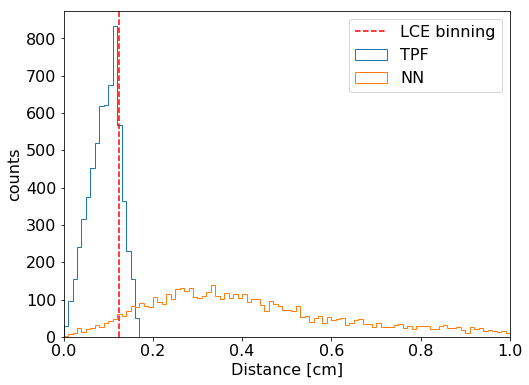

In [67]:
# Check if postions make sense
plt.rcParams['font.size'] = 16
d_range = 1
plt.figure(figsize=(8,6))
plt.hist(true_pos['d_tpf'], bins=100, range=(0, d_range), histtype='step', label='TPF')
plt.hist(true_pos['d_nn'], bins=100, range=(0, d_range), histtype='step', label='NN')
plt.axvline(1/8, color='red', linestyle='--', label='LCE binning')
plt.xlim(0, d_range)
plt.xlabel('Distance [cm]')
plt.ylabel('counts')
plt.legend()
plt.savefig('d_tpf_nn_simple.png', dpi=150)
plt.show()

In [70]:
# Save the positions (drop the patterns since these take up a lot of space)
true_pos.drop('pattern', inplace=True, axis=1)

true_pos.to_hdf('reconstructed_postions_simple.hdf', key='pos')

In [72]:
# How to load this back into python
data = pd.read_hdf('reconstructed_postions_simple.hdf', key='pos')

In [73]:
data.head()

,x,y,x_rec,y_rec,x_rec_nn,y_rec_nn,d_tpf,d_nn
0,2.626434,-17.960824,2.520230,-17.881634,2.535508,-18.200328,0.132478,0.256184
1,10.907536,-6.312277,10.920998,-6.360581,11.275090,-6.346362,0.050145,0.369130
2,2.726006,37.749081,2.760252,37.803454,3.125084,37.720948,0.064259,0.400069
3,-21.259064,-4.445240,-21.241941,-4.440406,-21.017482,-3.832932,0.017792,0.658242
4,-18.078293,-23.212466,-18.121656,-23.162116,-17.869011,-22.379250,0.066449,0.859097
